In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chisquare, pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics

from sklearn.metrics import ConfusionMatrixDisplay

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preprocessing

In [8]:
df = pd.read_csv('firstweek_features_binary.csv').drop('Unnamed: 0', axis=1)

In [9]:
df.head()

,Has_location,Has_username,Followers,Followees,Age_account,Total_tweets,Favourite,Groups,Has_Image,Aver_favourite,...,Has_tvshow,Posted_noon,Posted_weeke,Posted_eve,Has_excl,Num_hashtag,Opt_len,Has_suggest,Has_video,@@class@@
0,0,0,39113.0,10.0,421.0,1221.0,145.0,1489.0,1,0.34,...,0,0,1,0,0,0.0,0,0,0,1
1,0,0,663748.0,28.0,2025.0,4658.0,3.0,631.0,0,0.00,...,0,0,1,0,0,0.0,0,0,0,1
2,1,0,1836.0,597.0,242.0,272.0,0.0,3.0,0,0.00,...,0,0,1,1,0,0.0,0,0,0,1
3,0,0,3494.0,4617.0,226.0,1548.0,711.0,29.0,0,3.15,...,0,0,0,0,0,0.0,0,0,0,1
4,0,0,523.0,714.0,375.0,5715.0,3201.0,1.0,0,8.54,...,0,0,1,0,1,0.0,0,0,0,1


In [10]:
# Functions
def calc_ttest(df, pred, resp, values):
    assert len(values) == 2
    
    subset1 = df[df[resp] == values[0]]
    subset2 = df[df[resp] == values[1]]
    
    return ttest_ind(subset1[pred], subset2[pred], equal_var=False)

def filter_significant_t(df, cls, alpha):
    col_list = []
    columns = list(df.columns)
    columns.remove(cls)
    
    for col in columns:
        result = calc_ttest(df, col, cls, [0, 1])
        
        if result.pvalue <= alpha:
            col_list.append(col)
    
    return df[col_list]

def calc_chisquare(df, pred, resp, value, silent=False):
    subset = df[df[resp] == value]
    true_unique, true_counts = np.unique(df[pred], return_counts=True)
    
    unique, counts = np.unique(subset[pred], return_counts=True)
    sample_counts = np.zeros(len(true_counts))
    
    for attr, count in zip(unique, counts):
        pos = np.where(true_unique == attr)[0][0]
        sample_counts[pos] = count
        
    scaled_counts = len(df)*sample_counts/len(subset)
    if not silent:
        print(scaled_counts)
        print(true_counts)
    return chisquare(scaled_counts, true_counts)

def filter_significant_x2(df, cls, alpha):
    col_list = []
    columns = list(df.columns)
    columns.remove(cls)
#     print(columns)
    
    for col in columns:
        result0 = calc_chisquare(df, col, cls, 0, silent=True)
        result1 = calc_chisquare(df, col, cls, 1, silent=True)
        
        if result0.pvalue <= alpha or result1.pvalue <= alpha:
            col_list.append(col)
    
    return df[col_list]

def numerify(x):
    if x == 'positive':
        return 1
    if x == 'negative':
        return -1
    else:
        return 0

In [11]:
continuous_cols = ['Followers',
                 'Followees',
                 'Age_account',
                 'Total_tweets',
                 'Favourite', 
                 'Groups', 
                 'Aver_favourite', 
                 'Length_tweet',
                 'Aver_tweets',
                 'Name_length',
                 '@@class@@']

continuous = df[continuous_cols]
continuous_cols.remove('@@class@@')
discrete = df.drop(continuous_cols, axis=1)

In [12]:
significant_continuous = filter_significant_t(continuous, '@@class@@', 0.05)

In [13]:
significant_discrete = filter_significant_x2(discrete, '@@class@@', 0.05)

In [14]:
significant_discrete

,Has_location,Has_username,Has_Image,Contain_URL,Sent_level,Has_Uword,Posted_holiday,Has_number,Has_rt,Has_org,Has_tvshow,Posted_noon,Posted_weeke,Posted_eve,Has_excl,Num_hashtag,Opt_len,Has_suggest,Has_video
0,0,0,1,1,negative,0,1,0,0,0,0,0,1,0,0,0.0,0,0,0
1,0,0,0,0,positive,0,1,1,0,0,0,0,1,0,0,0.0,0,0,0
2,1,0,0,1,negative,0,1,0,0,0,0,0,1,1,0,0.0,0,0,0
3,0,0,0,1,negative,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0
4,0,0,0,0,negative,0,1,0,0,0,0,0,1,0,1,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043131,0,0,1,1,positive,0,0,0,0,0,0,0,1,0,1,0.0,0,0,0
6043132,0,0,0,0,positive,0,0,1,0,0,0,0,1,0,1,0.0,1,0,0
6043133,0,0,0,0,negative,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0
6043134,0,0,0,1,negative,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0


In [15]:
significant_continuous

,Followers,Followees,Age_account,Total_tweets,Favourite,Groups,Aver_favourite,Length_tweet,Aver_tweets,Name_length
0,39113.0,10.0,421.0,1221.0,145.0,1489.0,0.34,111.0,2.90,11.0
1,663748.0,28.0,2025.0,4658.0,3.0,631.0,0.00,45.0,2.30,16.0
2,1836.0,597.0,242.0,272.0,0.0,3.0,0.00,156.0,1.12,6.0
3,3494.0,4617.0,226.0,1548.0,711.0,29.0,3.15,74.0,6.85,15.0
4,523.0,714.0,375.0,5715.0,3201.0,1.0,8.54,42.0,15.24,8.0
...,...,...,...,...,...,...,...,...,...,...
6043131,2.0,796.0,8.0,23.0,9.0,0.0,1.13,77.0,2.88,5.0
6043132,2087.0,648.0,2451.0,163551.0,249632.0,7.0,101.85,85.0,66.73,13.0
6043133,21.0,18.0,1271.0,1677.0,48.0,1.0,0.04,44.0,1.32,6.0
6043134,4.0,54.0,1206.0,265.0,1.0,0.0,0.00,49.0,0.22,18.0


In [16]:
Sent_level = significant_discrete['Sent_level'].apply(numerify)
significant_discrete.drop('Sent_level', axis=1)
significant_discrete = significant_discrete.assign(Sent_level = Sent_level)

In [17]:
np.unique(significant_discrete['Sent_level'])

array([-1,  0,  1], dtype=int64)

In [18]:
significant = significant_discrete.join(significant_continuous)
significant.head()

,Has_location,Has_username,Has_Image,Contain_URL,Sent_level,Has_Uword,Posted_holiday,Has_number,Has_rt,Has_org,...,Followers,Followees,Age_account,Total_tweets,Favourite,Groups,Aver_favourite,Length_tweet,Aver_tweets,Name_length
0,0,0,1,1,-1,0,1,0,0,0,...,39113.0,10.0,421.0,1221.0,145.0,1489.0,0.34,111.0,2.90,11.0
1,0,0,0,0,1,0,1,1,0,0,...,663748.0,28.0,2025.0,4658.0,3.0,631.0,0.00,45.0,2.30,16.0
2,1,0,0,1,-1,0,1,0,0,0,...,1836.0,597.0,242.0,272.0,0.0,3.0,0.00,156.0,1.12,6.0
3,0,0,0,1,-1,0,0,0,0,0,...,3494.0,4617.0,226.0,1548.0,711.0,29.0,3.15,74.0,6.85,15.0
4,0,0,0,0,-1,0,1,0,0,0,...,523.0,714.0,375.0,5715.0,3201.0,1.0,8.54,42.0,15.24,8.0


# Model

In [21]:
X, y = significant, df['@@class@@']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [23]:
X_train.shape

(4834508, 29)

In [24]:
X_test.shape

(1208628, 29)

In [25]:
y_train.shape

(4834508,)

In [26]:
y_test.shape

(1208628,)

In [27]:
input_shape = (X.shape[1],)
batch_size = 512
learning_rate = 1e-3
epochs = 50

In [20]:
model = keras.Sequential([
    layers.Dense(128, input_shape=input_shape, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(256, input_shape=input_shape, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

In [21]:
model.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer = optimizers.Adam(learning_rate),
    metrics = [metrics.BinaryAccuracy()]
)

In [22]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
9443/9443 [==============================] - 24s 2ms/step - loss: 31.0590 - binary_accuracy: 0.6703
Epoch 2/50
9443/9443 [==============================] - 24s 3ms/step - loss: 0.6500 - binary_accuracy: 0.6661
Epoch 3/50
9443/9443 [==============================] - 21s 2ms/step - loss: 0.6056 - binary_accuracy: 0.6806
Epoch 4/50
9443/9443 [==============================] - 21s 2ms/step - loss: 0.5689 - binary_accuracy: 0.7806
Epoch 5/50
9443/9443 [==============================] - 21s 2ms/step - loss: 0.5838 - binary_accuracy: 0.7823
Epoch 6/50
9443/9443 [==============================] - 20s 2ms/step - loss: 0.5742 - binary_accuracy: 0.7804
Epoch 7/50
9443/9443 [==============================] - 21s 2ms/step - loss: 0.5333 - binary_accuracy: 0.7815
Epoch 8/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5357 - binary_accuracy: 0.7786
Epoch 9/50
9443/9443 [==============================] - 22s 2ms/step - loss: 0.5308 - binary_accuracy: 0.7816
Epoch 10/

In [23]:
model.evaluate(X_test, y_test, batch_size=batch_size)

2361/2361 [==============================] - 3s 1ms/step - loss: 0.4801 - binary_accuracy: 0.7860


[0.48007869720458984, 0.7859945297241211]

In [24]:
model.evaluate(X_train, y_train, batch_size=batch_size)

9443/9443 [==============================] - 13s 1ms/step - loss: 0.4803 - binary_accuracy: 0.7860


[0.48030444979667664, 0.7860434055328369]

In [27]:
model2 = keras.Sequential([
    layers.Dense(128, input_shape=input_shape, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(256, input_shape=input_shape, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

In [28]:
model2.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer = optimizers.Adam(learning_rate),
    metrics = [metrics.BinaryAccuracy()]
)

In [29]:
model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
9443/9443 [==============================] - 24s 3ms/step - loss: 30.1005 - binary_accuracy: 0.6922
Epoch 2/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5870 - binary_accuracy: 0.7401
Epoch 3/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5632 - binary_accuracy: 0.7692
Epoch 4/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5508 - binary_accuracy: 0.7740
Epoch 5/50
9443/9443 [==============================] - 24s 2ms/step - loss: 0.5562 - binary_accuracy: 0.7751
Epoch 6/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5568 - binary_accuracy: 0.7756
Epoch 7/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5569 - binary_accuracy: 0.7725
Epoch 8/50
9443/9443 [==============================] - 24s 3ms/step - loss: 0.5571 - binary_accuracy: 0.7741
Epoch 9/50
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5462 - binary_accuracy: 0.7761
Epoch 10/

In [35]:
model2.fit(X_train, y_train, epochs=10, batch_size=batch_size)

Epoch 1/10
9443/9443 [==============================] - 23s 2ms/step - loss: 0.5488 - binary_accuracy: 0.7641
Epoch 2/10
9443/9443 [==============================] - 34s 4ms/step - loss: 0.5479 - binary_accuracy: 0.7629
Epoch 3/10
9443/9443 [==============================] - 37s 4ms/step - loss: 0.5475 - binary_accuracy: 0.7648
Epoch 4/10
9443/9443 [==============================] - 25s 3ms/step - loss: 0.5537 - binary_accuracy: 0.7589
Epoch 5/10
9443/9443 [==============================] - 35s 4ms/step - loss: 0.5517 - binary_accuracy: 0.7588
Epoch 6/10
9443/9443 [==============================] - 36s 4ms/step - loss: 0.5493 - binary_accuracy: 0.7633
Epoch 7/10
9443/9443 [==============================] - 28s 3ms/step - loss: 0.5454 - binary_accuracy: 0.7670
Epoch 8/10
9443/9443 [==============================] - 27s 3ms/step - loss: 0.5517 - binary_accuracy: 0.7708
Epoch 9/10
9443/9443 [==============================] - 25s 3ms/step - loss: 0.5461 - binary_accuracy: 0.7699
Epoch 10/1

In [36]:
model2.evaluate(X_test, y_test, batch_size=batch_size)

2361/2361 [==============================] - 3s 1ms/step - loss: 0.5370 - binary_accuracy: 0.7680


[0.5369839072227478, 0.7679749131202698]

In [37]:
model2.evaluate(X_train, y_train, batch_size=batch_size)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [4]:
class ResidualDense(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.dense = layers.Dense(*args, **kwargs)
        self.add = layers.Add()
  
    def call(self, inputs):
        assert inputs.shape[1] == self.dense.units
        return self.add([inputs, self.dense(inputs)])

In [39]:
model3 = keras.Sequential([
    layers.Dense(128, input_shape=input_shape, activation=tf.nn.relu),
    layers.BatchNormalization(),

    ResidualDense(128, activation=tf.nn.relu),

    ResidualDense(128, activation=tf.nn.relu),

    ResidualDense(128, activation=tf.nn.relu),

    layers.Dense(256, activation=tf.nn.relu),
    layers.Dropout(0.5),

    ResidualDense(256, activation=tf.nn.relu),

    ResidualDense(256, activation=tf.nn.relu),

    ResidualDense(256, activation=tf.nn.relu),

    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.5),

    ResidualDense(512, activation=tf.nn.relu),

    ResidualDense(512, activation=tf.nn.relu),

    ResidualDense(512, activation=tf.nn.relu),

    layers.Dense(1)
])
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               3840      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 residual_dense_18 (Residual  (None, 128)              16512     
 Dense)                                                          
                                                                 
 residual_dense_19 (Residual  (None, 128)              16512     
 Dense)                                                          
                                                                 
 residual_dense_20 (Residual  (None, 128)              16512     
 Dense)                                               

In [40]:
model3.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer = optimizers.Adam(learning_rate),
    metrics = [metrics.BinaryAccuracy()]
)

In [41]:
model3.fit(X_train, y_train, epochs=80, batch_size=batch_size)

Epoch 1/80
9443/9443 [==============================] - 43s 4ms/step - loss: 0.4568 - binary_accuracy: 0.7841
Epoch 2/80
9443/9443 [==============================] - 42s 4ms/step - loss: 0.4340 - binary_accuracy: 0.7954
Epoch 3/80
9443/9443 [==============================] - 43s 5ms/step - loss: 0.4253 - binary_accuracy: 0.8008
Epoch 4/80
9443/9443 [==============================] - 40s 4ms/step - loss: 0.4208 - binary_accuracy: 0.8031
Epoch 5/80
9443/9443 [==============================] - 40s 4ms/step - loss: 0.4179 - binary_accuracy: 0.8045
Epoch 6/80
9443/9443 [==============================] - 42s 4ms/step - loss: 0.4154 - binary_accuracy: 0.8060
Epoch 7/80
9443/9443 [==============================] - 39s 4ms/step - loss: 0.4128 - binary_accuracy: 0.8074
Epoch 8/80
9443/9443 [==============================] - 39s 4ms/step - loss: 0.4110 - binary_accuracy: 0.8084
Epoch 9/80
9443/9443 [==============================] - 40s 4ms/step - loss: 0.4105 - binary_accuracy: 0.8088
Epoch 10/8

9443/9443 [==============================] - 44s 5ms/step - loss: 0.4106 - binary_accuracy: 0.8089
Epoch 75/80
9443/9443 [==============================] - 44s 5ms/step - loss: 0.4096 - binary_accuracy: 0.8093
Epoch 76/80
9443/9443 [==============================] - 44s 5ms/step - loss: 0.4077 - binary_accuracy: 0.8103
Epoch 77/80
9443/9443 [==============================] - 43s 5ms/step - loss: 0.4074 - binary_accuracy: 0.8103
Epoch 78/80
9443/9443 [==============================] - 42s 4ms/step - loss: 0.4068 - binary_accuracy: 0.8105
Epoch 79/80
9443/9443 [==============================] - 44s 5ms/step - loss: 0.4121 - binary_accuracy: 0.8083
Epoch 80/80
9443/9443 [==============================] - 43s 5ms/step - loss: 0.4094 - binary_accuracy: 0.8095


In [42]:
model3.evaluate(X_test, y_test, batch_size=batch_size)

2361/2361 [==============================] - 7s 2ms/step - loss: 0.4788 - binary_accuracy: 0.7218


[0.4787660539150238, 0.7217729687690735]

In [45]:
y_pred = model3.predict(X_test)

37770/37770 [==============================] - 54s 1ms/step


In [54]:
tf.round(tf.nn.sigmoid(y_pred))

<tf.Tensor: shape=(1208628, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

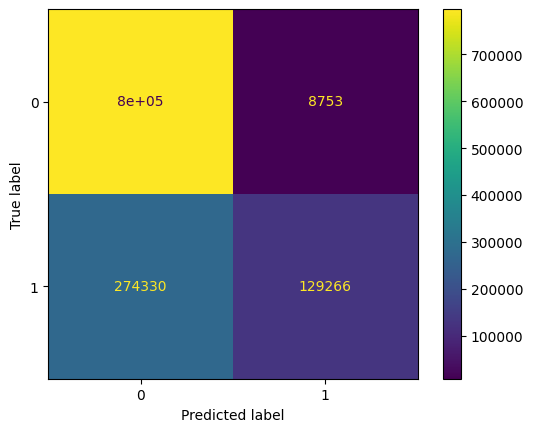

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(tf.nn.sigmoid(y_pred)))